In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import torch

In [2]:
df = pd.read_csv(os.path.join("datasets", "A0152_1.csv"))

In [3]:
X = df.to_numpy()[:, 1:-1]
# Normalize data
width_original = 1920
height_original = 1080
X[:, ::2] = X[:, ::2] / width_original
X[:, 1::2] = X[:, 1::2] / height_original

In [4]:
n = 100
frame = X[n, :]

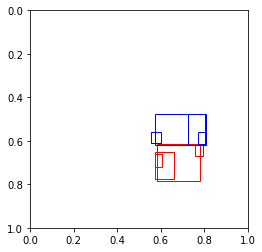

In [5]:
fig, ax = plt.subplots()
for i in range(len(frame)//4):
    if i < 4:
        edgecolor = 'r'
    else:
        edgecolor = 'b'
    x = frame[i*4]
    y = frame[i*4+1]
    w = frame[i*4+2]
    h = frame[i*4+3]
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().invert_yaxis()
plt.show()

In [6]:
def box_to_points(box):
    # type np array, shape of input: (n, 4), columns: top left x, top left y, width, height
    pts = np.zeros((box.shape[0], box.shape[1]*2))
    pts[:, :2] = box[:, :2]
    pts[:, 2] = box[:, 0] + box[:, 2]
    pts[:, 3] = box[:, 1]
    pts[:, 4] = box[:, 0]
    pts[:, 5] = box[:, 1] + box[:, 3]
    pts[:, 6:] = box[:, :2] + box[:, 2:]
    return pts

In [63]:
def get_centerpoint(corners):
    # type np array, shape of input: n(n, t, 8), columns: x, y positions of points in clockwise direction
    min_x = np.min(corners[:, :, ::2], axis=2)
    max_x = np.max(corners[:, :, ::2], axis=2)
    min_y = np.min(corners[:, :, 1::2], axis=2)
    max_y = np.max(corners[:, :, 1::2], axis=2)
    return np.vstack(((min_x+max_x)/2, (min_y+max_y)/2)).T

In [64]:
'''
def redraw(center_point, old_width, old_height):
    sqrtA = np.sqrt(old_width*old_height)
    new_width = np.where(old_width < old_height, np.sqrt(2)*sqrtA, np.sqrt(2)/2*sqrtA)
    new_height = np.where(old_width < old_height, np.sqrt(2)/2*sqrtA, np.sqrt(2)*sqrtA)
    return np.vstack(((center_point[:,0] - new_width/2),
                      (center_point[:,1] - new_height/2),
                      (center_point[:,0] + new_width/2),
                      (center_point[:,1] - new_height/2),
                      (center_point[:,0] - new_width/2),
                      (center_point[:,1] + new_height/2),
                      (center_point[:,0] + new_width/2),
                      (center_point[:,1] + new_height/2))).T

def redraw(corners, center_point, old_width, old_height):
    min_x = np.min(corners[:, ::2], axis=1)
    max_x = np.max(corners[:, ::2], axis=1)
    min_y = np.min(corners[:, 1::2], axis=1)
    max_y = np.max(corners[:, 1::2], axis=1)
    sqrtA = np.sqrt(old_width*old_height)
    #ub = 2*(center_point[:,0]-min_x)
    lb = old_width*old_height/(2*(max_y-center_point[:,1]))
    #print(lb < ub)
    sqrtA = np.where(sqrtA < lb, lb, sqrtA)
    #sqrtA = np.where(sqrtA > ub, ub, sqrtA)
    sqrtAp = old_width*old_height/sqrtA
   
    new_width = np.where(max_x-min_x > max_y-min_y, np.maximum(sqrtA, sqrtAp), np.minimum(sqrtA, sqrtAp))
    new_height = np.where(max_x-min_x > max_y-min_y, np.minimum(sqrtA, sqrtAp), np.maximum(sqrtA, sqrtAp))
    return np.vstack(((center_point[:,0] - new_width/2),
                      (center_point[:,1] - new_height/2),
                      (center_point[:,0] + new_width/2),
                      (center_point[:,1] - new_height/2),
                      (center_point[:,0] - new_width/2),
                      (center_point[:,1] + new_height/2),
                      (center_point[:,0] + new_width/2),
                      (center_point[:,1] + new_height/2))).T
'''
def redraw(corners, center_point, old_width, old_height):
    min_x = np.min(corners[:, :, ::2], axis=2)
    max_x = np.max(corners[:, :, ::2], axis=2)
    min_y = np.min(corners[:, :, 1::2], axis=2)
    max_y = np.max(corners[:, :, 1::2], axis=2)
    height2width = (max_y-min_y)/(max_x-min_x)
    area = old_width * old_height
    new_width = np.sqrt(area/height2width)
    new_height = area/new_width
    return np.vstack(((center_point[:,:,0] - new_width/2),
                      (center_point[:,:,1] - new_height/2),
                      (center_point[:,:,0] + new_width/2),
                      (center_point[:,:,1] - new_height/2),
                      (center_point[:,:,0] - new_width/2),
                      (center_point[:,:,1] + new_height/2),
                      (center_point[:,:,0] + new_width/2),
                      (center_point[:,:,1] + new_height/2))).T

In [9]:
# Transform from bounding box to corner points
X_pts = np.zeros((X.shape[0], X.shape[1]*2))
for i in range(X.shape[1]//4):
    X_pts[:, i*8:(i+1)*8] = box_to_points(X[:, i*4:(i+1)*4])

In [56]:
n = 47
frame = X_pts[n, :]

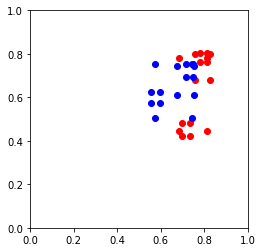

In [57]:
fig, ax = plt.subplots()
for i in range(len(frame)//2):
    if i < 16:
        c = 'r'
    else:
        c = 'b'
    plt.scatter(frame[i*2], frame[i*2+1], c=c)
plt.gca().invert_yaxis()
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

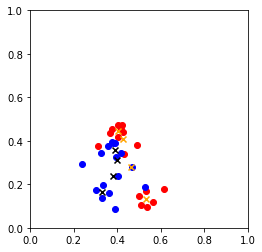

In [58]:
frame_aug = augment_data(X_pts.reshape(len(X_pts),1,-1), velocity=False)
frame = frame_aug[n, 0]
fig, ax = plt.subplots()
for i in range(len(frame)//2):
    if i < 16:
        c = 'r'
    else:
        c = 'b'
    plt.scatter(frame[i*2], frame[i*2+1], c=c)

for i in range(len(frame)//8):
    if i < 4:
        c = 'orange'
    else:
        c = 'black'
    cxy = get_centerpoint(frame[i*8: (i+1)*8].reshape(1,-1))
    plt.scatter(cxy[:,0], cxy[:,1], c=c, marker='x')
plt.gca().invert_yaxis()
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [59]:
center_pts = np.zeros((len(frame_aug), 16))
for i in range(frame_aug.shape[-1]//8):
    center_pts[:, i*2:(i+1)*2] = get_centerpoint(frame_aug[:, 0, i*8: (i+1)*8])

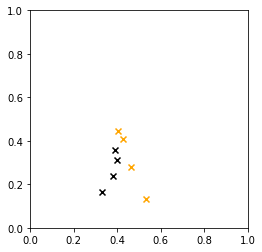

In [60]:
frame_cpt = center_pts[n, :]
fig, ax = plt.subplots()
for i in range(len(frame_cpt)//2):
    if i < 4:
        c = 'orange'
    else:
        c = 'black'
    cx, cy = (frame_cpt[i*2], frame_cpt[i*2+1])
    plt.scatter(cx, cy, c=c, marker='x')
plt.gca().invert_yaxis()
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [61]:
redrawn_pts = np.zeros_like(X_pts)
for i in range(center_pts.shape[1]//2):
    old_width = X[:, i*4+2]
    old_height = X[:, i*4+3]
    center_point = center_pts[:, i*2: (i+1)*2]
    points = frame_aug[:, 0, i*8: (i+1)*8]
    redrawn_pts[:, i*8: (i+1)*8] = redraw(points, center_point, old_width, old_height)

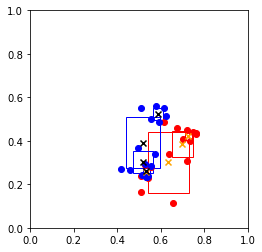

In [62]:
from matplotlib.pyplot import cm
n= 10
frame = redrawn_pts[n]
fig, ax = plt.subplots()
for i in range(len(frame)//8):
    if i < 4:
        c = 'r'
    else:
        c = 'b'
    #plt.scatter(frame[i*2], frame[i*2+1], c=c)
    x = frame[i*8]
    y = frame[i*8+1]
    w = frame[i*8+2] - x
    h = frame[i*8+5] - y
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=c, facecolor='none')
    ax.add_patch(rect)

aug = frame_aug[n, 0] 
for i in range(len(aug)//2):
    if i < 16:
        c = 'r'
    else:
        c = 'b'
    plt.scatter(aug[i*2], aug[i*2+1], c=c)
    
for i in range(len(frame)//8):
    if i < 4:
        c = 'orange'
    else:
        c = 'black'
    cxy = get_centerpoint(frame[i*8: (i+1)*8].reshape(1,-1))
    plt.scatter(cxy[:,0], cxy[:,1], c=c, marker='x')
plt.gca().invert_yaxis()
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [13]:
def augment_data(x_in, mirror=True, shift=True, rotate=True):
    # hardcoded order of x_in, corner points: 0-63, velocity of center points: 64-79, overlap between boxes: 80-95
    point_features = 64
    velocity_features = 80

    if type(x_in) == torch.Tensor:
        x = x_in.cpu().numpy().copy()
        x = np.squeeze(x, 1)
    else:
        x = x_in.copy()

    if mirror:
        # flip x
        chosen = np.random.choice(len(x), len(x) // 2, replace=False)
        x[chosen, :, 0:point_features:2] = 1 - x[chosen, :, 0:point_features:2]
        x[chosen, :, point_features:velocity_features:2] = -x[chosen, :, point_features:velocity_features:2]

        # flip y
        chosen = np.random.choice(len(x), len(x) // 2, replace=False)
        x[chosen, :, 1:point_features:2] = 1 - x[chosen, :, 1:point_features:2]
        x[chosen, :, point_features + 1:velocity_features:2] = -x[chosen, :, point_features + 1:velocity_features:2]

    if rotate:
        # rotate randomly
        theta = np.random.random(size=(len(x))) * np.pi * 2
        cos = np.cos(theta)
        sin = np.sin(theta)
        rotation_matrix = np.transpose(np.array([[cos, -sin], [sin, cos]]), [2, 1, 0])
        bs, seqlength, feats = x[:, :, 0:point_features:2].shape
        cg_x = np.sum(x[:, :, 0:point_features:2], axis=1) / (bs * seqlength * feats)
        cg_y = np.sum(x[:, :, 1:point_features:2], axis=1) / (bs * seqlength * feats)
        rotated = np.matmul(rotation_matrix, np.stack(
            (x[:, :, 0:point_features:2].reshape(bs, -1) - cg_x, x[:, :, 1:point_features:2].reshape(bs, -1) - cg_y), axis=1))

        rotated_v = np.matmul(rotation_matrix,
                              np.stack((x[:, :, point_features:velocity_features:2].reshape(bs, -1), 
                                        x[:, :, point_features + 1:velocity_features:2].reshape(bs, -1)), axis=1))
        
        xp = rotated[:, 0]
        yp = rotated[:, 1]
        xp = xp + cg_x
        yp = yp + cg_y
        xvp = rotated_v[:, 0]
        yvp = rotated_v[:, 1]
        x[:, :, 0:point_features:2] = xp.reshape(bs, seqlength, -1)
        x[:, :, 1:point_features:2] = yp.reshape(bs, seqlength, -1)
        x[:, :, point_features:velocity_features:2] = xvp.reshape(bs, seqlength, -1)
        x[:, :, point_features + 1:velocity_features:2] = yvp.reshape(bs, seqlength, -1)
        shift = True

    if shift:
        max_x = np.max(x[:, :, 0:point_features:2], axis=(1, 2))
        min_x = np.min(x[:, :, 0:point_features:2], axis=(1, 2))
        max_y = np.max(x[:, :, 1:point_features:2], axis=(1, 2))
        min_y = np.min(x[:, :, 1:point_features:2], axis=(1, 2))

        x_shift_range = 1 - max_x + min_x
        y_shift_range = 1 - max_y + min_y

        x_shift = np.random.random(size=(len(x))) * x_shift_range - min_x
        y_shift = np.random.random(size=(len(x))) * y_shift_range - min_y
        x[:, :, 0:point_features:2] = x[:, :, 0:point_features:2] + x_shift.reshape(-1, 1, 1)
        x[:, :, 1:point_features:2] = x[:, :, 1:point_features:2] + y_shift.reshape(-1, 1, 1)

    if rotate;
        center_pts = np.zeros((len(x_in), seqlength, velocity_features-point_features))
        for i in range(point_features//8):
            center_pts[:, :, i*2:(i+1)*2] = get_centerpoint(x[:, :, i*8: (i+1)*8])
    
        redrawn_pts = np.zeros((len(x_in), seqlength, point_features))
        for i in range(center_pts.shape[2]//2):
            old_width = X[:, :, i*4+2]
            old_height = X[:, :, i*4+3]
            center_point = center_pts[:, :, i*2: (i+1)*2]
            points = frame_aug[:, 0, i*8: (i+1)*8]
            redrawn_pts[:, :, i*8: (i+1)*8] = redraw(points, center_point, old_width, old_height)
        
    
    if type(x_in) == torch.Tensor:
        return torch.unsqueeze(torch.from_numpy(x), 1)
    else:
        return x